In [1]:
import numpy as np
import qiskit
from qiskit.quantum_info.operators import Operator
from qiskit.extensions import UnitaryGate
from tools import *

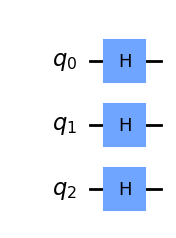

In [2]:
circ = QuantumCircuit(3)
circ.h(qubit=0)
circ.h(qubit=1)
circ.h(qubit=2)
circ.draw(output='mpl')

In [3]:
from qiskit.circuit.library import MCMT

In [4]:
c2z = MCMT('z', num_ctrl_qubits=2, num_target_qubits=1)  # see https://quantumcomputing.stackexchange.com/questions/28139/how-do-i-draw-a-multi-control-cz-gate-or-do-i-have-to-make-my-own-gate

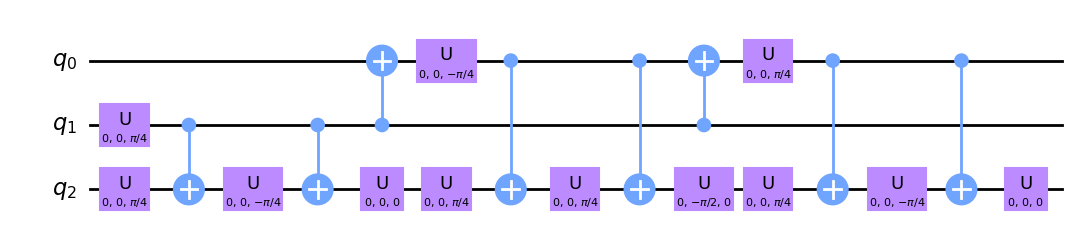

In [5]:
c2z.decompose().decompose().draw(output='mpl') # decomposition into 1- and 2-qubit gates

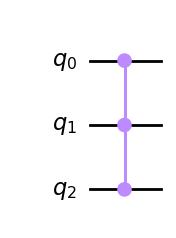

In [6]:
c2z.draw(output='mpl') # easier to read

In [7]:
circ.compose(c2z,inplace=True)

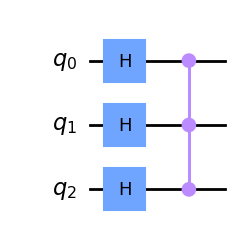

In [8]:
circ.draw('mpl')

In [9]:
type(circ)

qiskit.circuit.quantumcircuit.QuantumCircuit

In [10]:
# Run the quantum circuit on a statevector simulator backend
backend = Aer.get_backend('statevector_simulator')
job = backend.run(circ.decompose().decompose())  ## doesn't seem to work without the "decompose"

In [11]:
result = job.result()
statevector_result = np.real_if_close(np.array(result.data()['statevector']))
print(statevector_result)

[ 0.35355339  0.35355339  0.35355339  0.35355339  0.35355339  0.35355339
  0.35355339 -0.35355339]


The multi-control-Z gate sends |111> -> -|111> and |abc> -> |abc> for states with at least one qubit=0

What we want for the paper by Berry et al is more like formula (9) of arXiv:1711.10460.

In [12]:
circ2 = QuantumCircuit(4) ## adding some qubits.  Will try to "reflect" in just some of them.

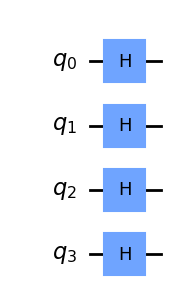

In [13]:
circ2.h(qubit=0)
circ2.h(qubit=1)
circ2.h(qubit=2)
circ2.h(qubit=3)
circ2.draw(output='mpl')

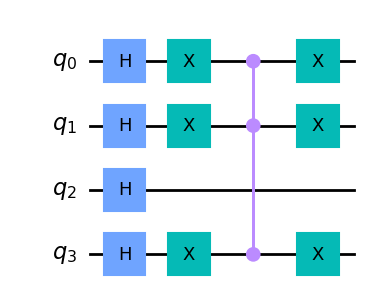

In [14]:
circ2.x(qubit=0) # X-gates (classical "not") to instead send |000> -> -|000> and |abc> -> |abc> if one qubit is 1
circ2.x(qubit=1)
circ2.x(qubit=3)
circ2.compose(c2z,qubits=[0,1,3],inplace=True)
circ2.x(qubit=0) # undo the X-gates
circ2.x(qubit=1)
circ2.x(qubit=3)
circ2.draw(output='mpl')

In [15]:
# Run the quantum circuit on a statevector simulator backend
backend = Aer.get_backend('statevector_simulator')
job = backend.run(circ2.decompose().decompose())
result = job.result()
statevector_result = np.real_if_close(np.array(result.data()['statevector']))
print(statevector_result)

[-0.25  0.25  0.25  0.25 -0.25  0.25  0.25  0.25  0.25  0.25  0.25  0.25
  0.25  0.25  0.25  0.25]


In the weird qiskit numbering, the two entries with a minus sign above correspond to |q_3 q_2 q_1 q_0> = |0000> and |0100>

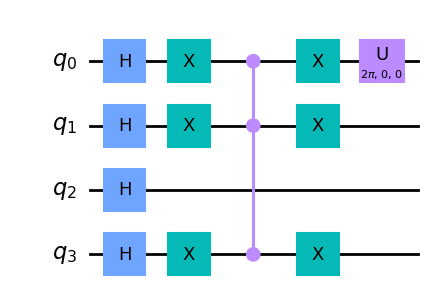

In [16]:
from math import pi
circ2.u(2*pi,0,0,0)  ## multiply by global phase of cos(pi) = -1, this is physically irrelevant but shows up in state vectors.
circ2.draw(output='mpl')

In [17]:
job = backend.run(circ2.decompose().decompose())
result = job.result()
statevector_result = np.real_if_close(np.array(result.data()['statevector']))
print(statevector_result)

[ 0.25 -0.25 -0.25 -0.25  0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25 -0.25
 -0.25 -0.25 -0.25 -0.25]


I think circ2 (without the Hadamards) represents the operator denoted "2 |0>_a <0|_a \otimes 1_s - 1" in equation (9) of arXiv:1711.10460, when the a-qubits are q_0, q_1, and q_3, and the s-qubit is here q_2